In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')



1. gathering data
------
use tools like wget in bashscripts to gather raw-data from the search-engine hosted at https://zeit.de

In [ ]:


# for i in $(seq 1 5000);do sleep 1; wget "https://www.zeit.de/suche/index?p=${i}" ;done

# for i in 2019-01- 2018-12- 2018-11- 2018-10- ;do echo "${i}"; egrep -ir "(teaser-small__datetime)" ./data/zeit.de/ | cut -d ":" -f 2- | tr -d "  " | sort -n | uniq | grep ${i} | wc -l;done
#
# 2019-01-
# 1901
# 2018-12-
# 1787
# 2018-11-
# 1914
# 2018-10-
# 2063

# egrep -ir "(teaser-small__byline|teaser-small__datetime|teaser-small__commentcount|teaser-small__text|teaser-small__title)"| cut -d ":" -f 2-  


2. extract data-points
--------
todays html-websites are very structured. looking at the code-inspector (F12) they off are like 
(meta ( type ( value ) ) ) or shorter / similar. BeautifulSoup gives an easy access to it.

For later use, the values are stored in an appending array. the two nodes (A,1) and (B,2) will be stored as the arrays
X=[A,B] and Y=[1,2] . the defaultdict provides an easy access to many of such arrays. 


In [ ]:
from bs4 import BeautifulSoup
import re
from collections import defaultdict
from datetime import datetime

data=defaultdict(list)
datafile="../data/zeit.de/index?p=%d"

t0=datetime.now()
for pagenumber in range(1,5000):
    if pagenumber % 250 == 0:
        print("%d - %s" %(pagenumber,datetime.now()-t0))
    with open(datafile %(pagenumber)) as fd:
        content = fd.read()
        soup = BeautifulSoup(content, 'html.parser')

        tcontainer = soup.find_all('div',attrs={'class':"teaser-small__container"})
        for tc in tcontainer:

            tmp = tc.find_all('span', attrs={'class':"teaser-small__title"})[0]
            data['title'].append(tmp.string)

            tmp = tc.find_all('p', attrs={'class':"teaser-small__text"})[0]
            data['teaser'].append(tmp.string)
            
            tmp = tc.find_all('time', attrs={'class':"teaser-small__datetime"})[0]
            data['timestamp'].append(tmp)
            
            tmp=tc.find('a', attrs={'title': "Kommentare anzeigen"})
            if tmp and len(tmp)>0:
                (number,_) = tmp.string.split(" ")
                number = number.replace(".","")
                
                (link,_) = tmp['href'].split("#")
                
                data['href'].append(link)
                data['comments'].append(int(number))
            else:
                data['href'].append("")
                data['comments'].append(0)
                
            tmp=tc.find_all('span', attrs={'class':"teaser-small__byline"})
            if len(tmp)>0:
                data['autoren'].append(tmp[0].string)
            else:
                data['autoren'].append("")                


3. enrich data with featureextration and additional parsing
----------
* some features can be easy extractet, like counting chars in a textfeld like title or teaser. adding an array with ones makes live easy later.


In [24]:

data['charTeaser']=[]
data['charTitle']=[]
data['count']=[]
for i in data['title']:
    if i:
        data['charTitle'].append(len(i))
    else:
        data['charTitle'].append(0)
for i in data['teaser']:
    if i:
        data['charTeaser'].append(len(i))
    else:
        data['charTeaser'].append(0)
for i in data['timestamp']:
    data['count'].append(1)
    

* timestamps need to become python-objects, by parsing the stringformat.

In [34]:
# parsing
timestamp = []
for t in data['timestamp']:
    if type(t) != type(datetime(year=1,month=1,day=1)):
        pubdate = t['datetime'].split("+")[0]
        timestamp.append(datetime.strptime(pubdate,"%Y-%m-%dT%H:%M:%S"))
    else:
        timestamp.append(t)
data['timestamp']=timestamp


* split joinded raw-fields with patternmatching into usable data-arrays

In [35]:
# im autorennamen ist die rubrik codiert.
autoren = []
rubriken = []

substitutions = {
    "Rezension": { 'pattern': "Eine Rezension von" } , 
    "Bericht": { 'pattern': "Von"},
    "Interview": { 'pattern': "Interview:"},
    "Analyse": { 'pattern': "Eine Analyse von"},
    "Gastbeitrag": { 'pattern': "Ein Gastbeitrag von"},
    "Reportage": { 'pattern': "Eine Reportage von"},
    "Protokoll": { 'pattern': "Protokoll:"},
    "Kommentar": { 'pattern': "Ein Kommentar von"},
    "Kolumne": { 'pattern': "Eine Kolumne von"},
    "Quiz": { 'pattern': "Quiz:"},
    "Essay": { 'pattern': "Ein Essay von"},
    "Glosse": { 'pattern': "Eine Glosse von"},
    "Visualisierung": { 'pattern': "Visualisierung:"}
}

for i in pattern:
    substitutions[i]['re']=re.compile("^"+substitutions[i]['pattern'] + "\s*")

for a in data['autoren']:
    a = a.strip()
    matched=False
    for rubrik in substitutions:
        if substitutions[rubrik]['re'].match(a) and matched==False:
            matched=True
            rubriken.append(rubrik)
            autoren.append( substitutions[rubrik]['re'].sub("",a) )
            
    if not matched:
        rubriken.append("Unerkannt")
        autoren.append(a)
    
    
data['rubrik']=rubriken
data['plain_autoren']=autoren

* cleanup some messy data

In [36]:
clean_autoren=[]
cleanup_pattern = {
    "und": { 
        'patter': " und ",
        'replace': ","
    },
            
    "u.a.": {
        'patter': " u.a.",
        'replace': ""
    }
}

for c in cleanup_pattern:
    cleanup_pattern[c]['re']=re.compile(".*"+cleanup_pattern[c]['patter'] + ".*",re.IGNORECASE)

for a in autoren:
    tmp = a
    for c in cleanup_pattern:
        if cleanup_pattern[c]['re'].match(tmp):
            if c=="u.a.":
                print(a)
            tmp = re.sub(cleanup_pattern[c]['patter'],cleanup_pattern[c]['replace'],tmp)
    #print("############" + str(tmp.split(",") ))
    tmp2 = []
    for i in tmp.split(","):
        tmp2.append(i.strip())
    clean_autoren.append(tmp2)
#print(len(clean_autoren))
#print(len(data['autoren']))

4. aggregate data into new data-arrays
--------------
https://github.com/lead-ratings/gender-guesser resp https://pypi.org/project/gender-guesser/ is the source of the function that is used to split the the autors. it's based on a list at https://github.com/lead-ratings/gender-guesser/blob/master/gender_guesser/data/nam_dict.txt 

from the documentation:
The result will be one of unknown (name not found), andy (androgynous), male, female, mostly_male, or mostly_female. The difference between andy and unknown is that the former is found to have the same probability to be male than to be female, while the later means that the name wasn't found in the database.

[snip from name_dict.txt]
<mostly male name (= unisex name, which is mostly male)> 
<mostly female name (= unisex name, which is mostly female)> 
<unisex name (= can be male or female)>  

this is changed: unknown, andy, mostly_male and mostly_female get the label 'unknown'

In [37]:
import gender_guesser.detector as gender

d = gender.Detector('de')
data['gender']=[]
for ca in clean_autoren:
        uniqGender=set()
        for a in ca:
            vorname = a.split(" ")[0]
            vorname = vorname.split("-")[0]
            if len(vorname) < 2:
                uniqGender.add('no autor')
            else:
                g = d.get_gender(vorname)
                if g in ['andy','mostly_male','mostly_female','unknown']:
                    uniqGender.add('unknown')
                else:
                    uniqGender.add(g)
        if len(uniqGender) == 1:
            data['gender'].append(list(uniqGender)[0])
        elif len(uniqGender) > 1:
            data['gender'].append('unknown')
        else:
            data['gender'].append('no author')
#print(len(data['gender']))

5. load the data into a pandas DataFrame
---------
* How is the distribution of the values; what are min max and mean values; how many datapoints do we have?

In [ ]:
from pandas import DataFrame

df=DataFrame(data)


In [48]:
df.describe(percentiles=[0.25,0.50,0.75,0.9,0.95,0.99,0.999])

charTeaser     charTitle      comments    count
count  48832.000000  48832.000000  48832.000000  48832.0
mean     153.665813     36.614658    124.648018      1.0
std       31.774598     14.330842    223.224301      0.0
min        0.000000      2.000000      0.000000      1.0
25%      152.000000     25.000000      0.000000      1.0
50%      164.000000     36.000000      0.000000      1.0
75%      168.000000     48.000000    189.000000      1.0
90%      170.000000     56.000000    389.000000      1.0
95%      171.000000     60.000000    554.000000      1.0
99%      216.000000     67.000000   1005.000000      1.0
99.9%    247.000000     73.000000   1704.197000      1.0
max      250.000000    101.000000   4580.000000      1.0

* what about those other values?

In [53]:
df[['href','rubrik','title','teaser','plain_autoren','timestamp','gender']].describe()

href     rubrik             title  \
count   48832      48832             48832   
unique  18775         14             47673   
top            Unerkannt  Lebensgeschichte   
freq    30056      22382               109   
first     NaN        NaN               NaN   
last      NaN        NaN               NaN   

                                                   teaser plain_autoren  \
count                                               48245         48832   
unique                                              48003          5056   
top     Jede Woche – die Liste der meistverkauften Büc...                 
freq                                                   45         22381   
first                                                 NaN           NaN   
last                                                  NaN           NaN   

                  timestamp  
count                 48832  
unique                48621  
top     2017-11-29 16:54:30  
freq                      3  
first   2014-02-19 21:02:08  
last    2019-02-11 20:22:22

* did we miss something?

In [55]:
df.head()

autoren  charTeaser  charTitle  \
0      Eine Rezension von            Barbara Stol...         168         26   
1                                                            170         42   
2                                                            123         34   
3                  Von            Alard von Kittlitz         168         24   
4                         Von            Tim Kröplin         168         57   

   comments  count    gender href               plain_autoren     rubrik  \
0         0      1    female       Barbara Stollberg-Rilinger  Rezension   
1         0      1  no autor                                   Unerkannt   
2         0      1  no autor                                   Unerkannt   
3         0      1   unknown               Alard von Kittlitz    Bericht   
4         0      1      male                      Tim Kröplin    Bericht   

                                              teaser           timestamp  \
0  Der Historiker Tim Blanning hat eine fulminant... 2019-02-11 20:22:22   
1  Der einzigen islamischen Kita von Rheinland-Pf... 2019-02-11 20:04:23   
2  In Berlin haben sich 1.000 junge Visionäre auf... 2019-02-11 19:30:44   
3  Eigentlich mochte unser Autor die Natur. Bis e... 2019-02-11 18:49:26   
4  Diagnose dank künstlicher Intelligenz: Forsche... 2019-02-11 18:41:04   

                                               title  
0                         Der eine Körper des Königs  
1         Muslimischer Kindergarten wird geschlossen  
2                 Das Z2X18-Festival in einer Minute  
3                           Fisch ohne Eigenschaften  
4  Ein Computerprogramm, das Husten von Asthma un...

* how do the distribution look for the given numbers? charTeaser is the length of the Teaser field of the raw-data. The y-axe counts the number of datapoints; the x-axe the length of the Teaser.

<IPython.core.display.Javascript object>


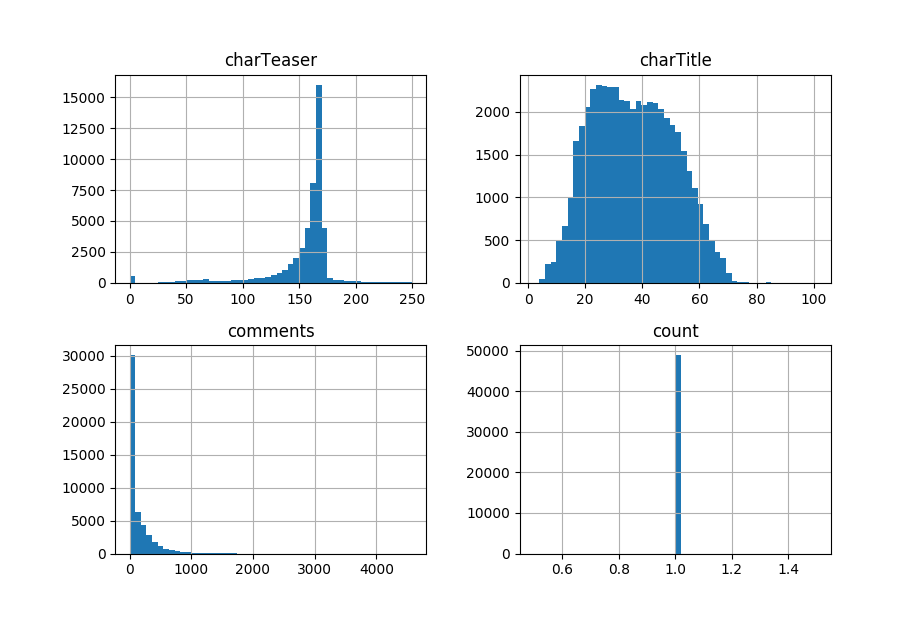

In [56]:
%matplotlib notebook

tmp=df.hist(bins=50)

6. aggregate the data
----------
Count provides the posibility to aggregate over different labels in the dataframe and showing the number of enries used for that aggregation.

In [ ]:
aggs = {
    'count': {
        'Anzahl': 'count',
        'zeit.de (%)': lambda x: "{:.2f}".format(len(x) * 100 / float(df['count'].sum()))
    },
    'charTitle': {
        'Summe': 'sum',
        'durchschnittlich': lambda x: "{:.2f}".format(x.mean()),
        'zeit.de (%)': lambda x: "{:.2f}".format(x.sum() * 100 / float(df['charTitle'].sum()))
        
    },
    'charTeaser': {
        'Summe': 'sum',
        'durchschnittlich': lambda x: "{:.2f}".format(x.mean()),
        'zeit.de (%)': lambda x: "{:.2f}".format(x.sum() * 100 / float(df['charTeaser'].sum()))
        
    },
    'comments': {
        'Summe': 'sum',
        'durchschnittlich': lambda x: "{:.2f}".format(x.mean()),
        'zeit.de (%)': lambda x: "{:.2f}".format(x.sum() * 100 / float(df['comments'].sum()))
        
    }

}

* by gender_guesser

In [57]:
gender = df.groupby(['gender']).agg(aggs).T

display(gender)

gender                        female     male no autor unknown
count      Anzahl               8842    15071    22381    2538
           zeit.de (%)         18.11    30.86    45.83    5.20
charTeaser durchschnittlich   147.46   144.83   162.56  149.29
           Summe             1303839  2182763  3638303  378904
           zeit.de (%)         17.38    29.09    48.49    5.05
comments   durchschnittlich   120.54   105.40   137.54  139.59
           Summe             1065823  1588433  3078288  354268
           zeit.de (%)         17.51    26.10    50.57    5.82
charTitle  durchschnittlich    29.80    29.32    44.91   30.47
           Summe              263469   441928  1005241   77329
           zeit.de (%)         14.74    24.72    56.22    4.32

* or a subselection of integer data

In [98]:
# subset of features
rubrik_s = df[['count','comments','rubrik']]
# group 
rubrik_g = rubrik_s.groupby(['rubrik'])
rubrik_s = rubrik_g
# aggregate the groups
rubrik_a = rubrik_g.aggregate({
    'comments':aggs['comments'],
    'count':aggs['count']
})

#rubrik = rubrik_a.sort_values(by=['rubrik','comments','durchschnitt'])

display(rubrik_a)

count                     comments                     
               Anzahl zeit.de (%) durchschnittlich    Summe zeit.de (%)
rubrik                                                                 
Analyse           457        0.94           341.75   156181        2.57
Bericht         21359       43.74            94.39  2016139       33.12
Essay              41        0.08           368.10    15092        0.25
Gastbeitrag       750        1.54           223.67   167753        2.76
Glosse             38        0.08            84.89     3226        0.05
Interview        2008        4.11           112.37   225643        3.71
Kolumne            95        0.19             1.07      102        0.00
Kommentar         905        1.85           375.78   340078        5.59
Protokoll         217        0.44           119.88    26014        0.43
Quiz               14        0.03            22.86      320        0.01
Reportage         143        0.29           318.98    45614        0.75
Rezension         420        0.86            21.00     8821        0.14
Unerkannt       22382       45.83           137.64  3080689       50.61
Visualisierung      3        0.01           380.00     1140        0.02

* or with more then one sublevel - in general more data is better

In [101]:
# subset of features
rg_s = df[['count','comments','rubrik','gender']]
# group 
rg_g = rg_s.groupby(['rubrik','gender'])
rg_s = rg_g
# aggregate the groups
rg_a = rg_g.aggregate({
    'comments':aggs['comments'],
    'count':aggs['count']
})

#rubrik = rubrik_a.sort_values(by=['rubrik','comments','durchschnitt'])

display(rg_a)


#gender_category = df.groupby(['rubrik','gender']).agg(aggs)

#display(gender_category)

count                     comments           \
                        Anzahl zeit.de (%) durchschnittlich    Summe   
rubrik         gender                                                  
Analyse        female      136        0.28           353.27    48045   
               male        282        0.58           322.41    90921   
               unknown      39        0.08           441.41    17215   
Bericht        female     7222       14.79           104.76   756559   
               male      12056       24.69            81.89   987250   
               no autor     35        0.07             0.00        0   
               unknown    2046        4.19           133.10   272330   
Essay          female        9        0.02           377.78     3400   
               male         29        0.06           367.79    10666   
               unknown       3        0.01           342.00     1026   
Gastbeitrag    female      121        0.25           204.69    24768   
               male        563        1.15           224.16   126201   
               unknown      66        0.14           254.30    16784   
Glosse         female       11        0.02           116.18     1278   
               male         23        0.05            68.39     1573   
               unknown       4        0.01            93.75      375   
Interview      female      784        1.61           133.27   104487   
               male        985        2.02           101.73   100207   
               unknown     239        0.49            87.65    20949   
Kolumne        female        1        0.00             0.00        0   
               male         94        0.19             1.09      102   
Kommentar      female      223        0.46           377.74    84235   
               male        635        1.30           377.52   239723   
               unknown      47        0.10           342.98    16120   
Protokoll      female      122        0.25           146.43    17864   
               male         71        0.15            79.25     5627   
               unknown      24        0.05           105.12     2523   
Quiz           female        3        0.01             0.00        0   
               male          8        0.02            40.00      320   
               unknown       3        0.01             0.00        0   
Reportage      female       64        0.13           348.94    22332   
               male         67        0.14           291.13    19506   
               unknown      12        0.02           314.67     3776   
Rezension      female      146        0.30            19.55     2855   
               male        255        0.52            20.38     5197   
               unknown      19        0.04            40.47      769   
Unerkannt      no autor  22346       45.76           137.76  3078288   
               unknown      36        0.07            66.69     2401   
Visualisierung male          3        0.01           380.00     1140   

                                     
                        zeit.de (%)  
rubrik         gender                
Analyse        female          0.79  
               male            1.49  
               unknown         0.28  
Bericht        female         12.43  
               male           16.22  
               no autor        0.00  
               unknown         4.47  
Essay          female          0.06  
               male            0.18  
               unknown         0.02  
Gastbeitrag    female          0.41  
               male            2.07  
               unknown         0.28  
Glosse         female          0.02  
               male            0.03  
               unknown         0.01  
Interview      female          1.72  
               male            1.65  
               unknown         0.34  
Kolumne        female          0.00  
               male            0.00  
Kommentar      female          1.38  
               male            3.94  
            

7. over time
----
select features and range. group the timestamp with a frequency of "by Month". Get number of documents in each group. calculte %-of each sub-group. 

<IPython.core.display.Javascript object>


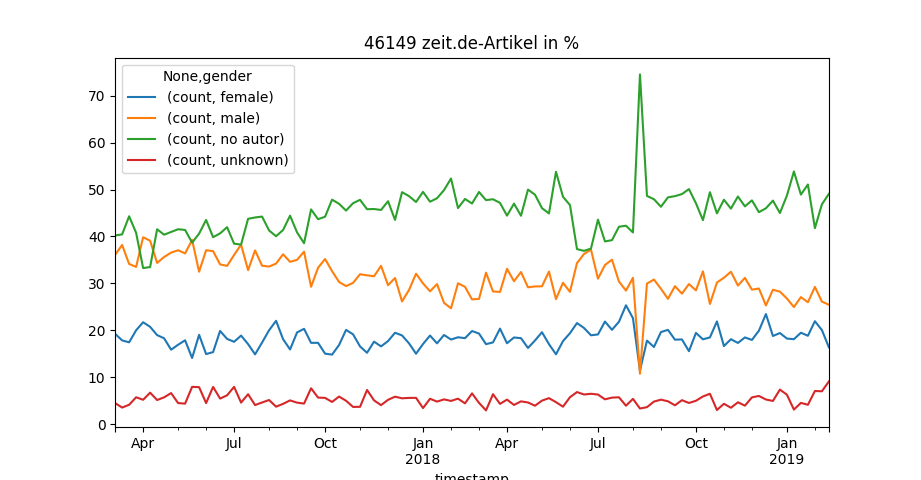

In [43]:
%matplotlib notebook

from pandas import Grouper

dfdate = df[['count','gender','timestamp']]
dfdate = dfdate.loc[dfdate['timestamp'] > datetime(year=2017,month=3,day=1)]
dfdate = dfdate.set_index(['timestamp'])

anz = len(dfdate['count'])

dfdate = dfdate.groupby([Grouper(freq="W"), 'gender']).agg({'count': 'sum'})

dfdate_pcts = dfdate.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))

tmp=dfdate_pcts.unstack().plot(title='%d zeit.de-Artikel in %%' %(anz))

* over coments instead of counts

<IPython.core.display.Javascript object>


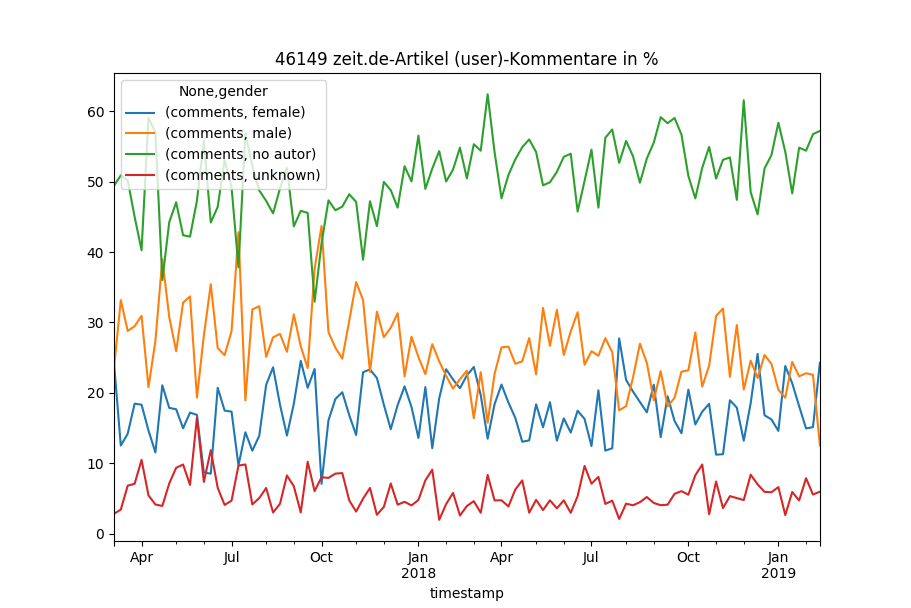

In [51]:
%matplotlib notebook

from pandas import Grouper

dfdate = df[['comments','gender','timestamp']]

dfdate = dfdate.loc[dfdate['timestamp'] > datetime(year=2017,month=3,day=1)]
dfdate = dfdate.set_index(['timestamp'])

anz = len(dfdate['comments'])

dfdate = dfdate.groupby([Grouper(freq="W"), 'gender'])
dfdate = dfdate.agg({'comments': 'sum'})

dfdate_pcts = dfdate.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))

tmp=dfdate_pcts.unstack().plot(title='%d zeit.de-Artikel (user)-Kommentare in %%' %(anz))